In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
import keras
from scipy.io import loadmat
from callbacks import *
from load_data import *
from keras.regularizers import l2
from Models.Base import BaseNN
from Models.PCA import PCANN
from Models.AA import AANN
from sklearn.decomposition import PCA

In [2]:
model = Sequential()
model.add(Dense(10, input_dim=400, activation='sigmoid'))# , kernel_regularizer = l2(0.07)))

X_train, X_test, y_train, y_test = load_small_mnist(0.4)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
loss_callback = LossCallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
itr_callback = IterationCallback(5)

model.fit(X_train, oneHot(y_train), epochs=20, batch_size=10, verbose=0, callbacks=[ca_callback, loss_callback])

In [3]:
from aa import AA

mid_dim1 = 15
mid_dim2 = 12
mid_dim3 = 11

dims = [15, 12, 11]

models = [Sequential() for m in range(len(dims)+1)]
models[0].add(Dense(dims[0], input_dim=400, activation='sigmoid'))
models[1].add(Dense(dims[1], input_dim=dims[0], activation='sigmoid'))
models[2].add(Dense(dims[2], input_dim=dims[1], activation='sigmoid'))
models[3].add(Dense(10, input_dim=dims[2], activation='sigmoid'))

for m in models:
    m.compile(loss='categorical_crossentropy', optimizer='adam')

X_train, X_test, y_train, y_test = load_small_mnist(0.2)

a1 = AA(X_train, dims[0])
a1.factorize(15)

a2 = AA(X_train, dims[1])
a2.factorize(15)

a3 = AA(X_train, dims[2])
a3.factorize(15)

aWs = [a1.W, a2.W, a3.W]

In [4]:
itras = 10
batch_size = 10
models[0].fit(X_train, aWs[0], epochs=itras, batch_size=batch_size, verbose=0)
models[1].fit(aWs[0], aWs[1], epochs=itras, batch_size=batch_size, verbose=0)
models[2].fit(aWs[1], aWs[2], epochs=itras, batch_size=batch_size, verbose=0)
models[3].fit(aWs[2], oneHot(y_train), epochs=itras, batch_size=batch_size, verbose=0)

weights1 = models[0].layers[0].get_weights()
weights2 = models[1].layers[0].get_weights()
weights2_5 = models[2].layers[0].get_weights()
weights2_6 = models[3].layers[0].get_weights()

model3 = Sequential()
model3.add(Dense(mid_dim1, input_dim=400, activation='sigmoid', weights = weights1))
model3.add(Dense(mid_dim2, input_dim=mid_dim1, activation='sigmoid', weights = weights2))
model3.add(Dense(mid_dim3, input_dim=mid_dim2, activation='sigmoid', weights = weights2_5))
model3.add(Dense(10, input_dim=mid_dim3, activation='sigmoid', weights = weights2_6))

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
model3.fit(X_train, oneHot(y_train), epochs=200, batch_size=20, verbose=0, callbacks=[ca_callback])
svd = ca_callback.get_data()

In [5]:
class RandomNN:
    def __init__(self, layers=[400, 25, 10]):
        self.model = Sequential()
        for i in range(len(layers)-1):
            self.model.add(Dense(layers[i+1], input_dim=layers[i]))
            self.model.add(Activation('sigmoid'))
        self.model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

    def fit(self, X_test, y_test, X_train, y_train, epochs = 200, batch_size = 10):
        ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
        self.model.fit(X_train, oneHot(y_train), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[ca_callback])
        return ca_callback.get_data()

In [6]:
base_model = PCANN([400, 15, 12, 11, 10])
pca = base_model.fit(X_test, y_test, X_train, y_train, 200, 20)
base_model = BaseNN([400, 15, 12, 11, 10])
random = base_model.fit(X_test, y_test, X_train, y_train, 200, 20)
base_model = RandomNN([400, 15, 12, 11, 10])
random1 = base_model.fit(X_test, y_test, X_train, y_train, 200, 20)

In [7]:
#base_model = LDANN([400, 15, 12, 11, 10])
#lda = base_model.fit(X_test, y_test, X_train, y_train, 100, 5)

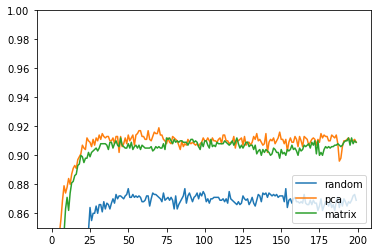

In [32]:
#plt.clear()
plt.plot(random[1], label = "random")
#plt.plot(random1[1], label = "random1")
plt.plot(pca[1], label = "pca")
plt.plot(svd[1], label = "matrix")
plt.legend(loc='lower right')
plt.ylim([0.85, 1])
plt.show()

In [69]:
from keras import regularizers
from keras.regularizers import l2
class AANN:
    def __init__(self, layers=[400, 25, 10], aa_iterations=15, regularizer_factor = 0):
        self.model = Sequential()
        self.layers = layers
        self.aa_iterations = aa_iterations
        self.regularizer_factor = regularizer_factor

    def fit(self, X_test, y_test, X_train, y_train, epochs=200, batch_size=10):

        #Layerwise data features
        layerwise_activations = [X_train]
        for i in range(1, len(self.layers) - 1):
            aa = AA(X_train, self.layers[i])
            aa.factorize(self.aa_iterations)#CHANGE
            aa_reduced_data = aa.W
            layerwise_activations.append(aa_reduced_data)
        layerwise_activations.append(oneHot(y_train))

        #Network mappings from i to i+1 layer
        mapping_neural_networks = []
        for i in range(len(self.layers) - 1):
            mapping_neural_network_model = Sequential()
            #Add 1 layer from input to output
            
#model.add(Dense(64, input_dim=64,
#                kernel_regularizer=regularizers.l2(0.01),
#                activity_regularizer=regularizers.l1(0.01)))

#model.add(Dense(64, 64, W_regularizer = l2(.01)))
            
            mapping_neural_network_model.add(Dense(self.layers[i + 1], 
                                                   input_dim=self.layers[i],
                                                   activation='sigmoid',
                                                   W_regularizer = l2(self.regularizer_factor)))
            mapping_neural_network_model.compile(loss='mean_squared_error', optimizer='adam')
            mapping_neural_network_model.fit(layerwise_activations[i], layerwise_activations[i + 1],
                                             epochs=30, batch_size=10, verbose=0)
            mapping_neural_networks.append(mapping_neural_network_model)

        ##Build model from calculated weights
        for i in range(len(self.layers) - 1):
            self.model.add(Dense(self.layers[i + 1],
                                 input_dim=self.layers[i],
                                 activation='sigmoid',
                                 weights=mapping_neural_networks[i].layers[0].get_weights()))

        self.model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

        # Generate callback for classification accuracy
        ca_callback = CACallback(X_test, oneHot(y_test), X_train, oneHot(y_train))
        self.model.fit(X_train, oneHot(y_train),
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=0,
                       callbacks=[ca_callback])
        # Return (train, test) accuracy tuple
        return ca_callback.get_data()



In [62]:
aamo1 = AANN([400, 15, 10], aa_iterations=40)
rnn1 = aamo1.fit(X_test, y_test, X_train, y_train, 500, 50)

aamo2 = AANN([400, 15, 10], aa_iterations=3)
rnn2 = aamo2.fit(X_test, y_test, X_train, y_train, 500, 50)

In [63]:
aamo3 = AANN([400, 15, 10], aa_iterations=100)
rnn3 = aamo3.fit(X_test, y_test, X_train, y_train, 500, 50)

In [64]:
aamo4 = AANN([400, 15, 10], aa_iterations=2)
rnn4 = aamo4.fit(X_test, y_test, X_train, y_train, 500, 50)

aamo5 = AANN([400, 15, 10], aa_iterations=1)
rnn5 = aamo5.fit(X_test, y_test, X_train, y_train, 500, 50)

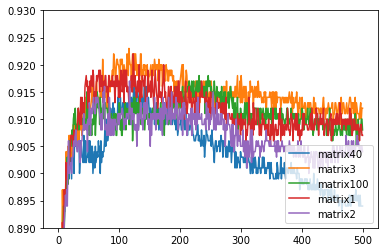

In [67]:
plt.plot(rnn1[1], label = "matrix40")
plt.plot(rnn2[1], label = "matrix3")
plt.plot(rnn3[1], label = "matrix100")
plt.plot(rnn5[1], label = "matrix1")
plt.plot(rnn4[1], label = "matrix2")
plt.legend(loc='lower right')
plt.ylim([0.89, 0.93])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, input_dim=400, activation="sigmoid", kernel_regularizer=<keras.reg...)`
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, input_dim=15, activation="sigmoid", kernel_regularizer=<keras.reg...)`


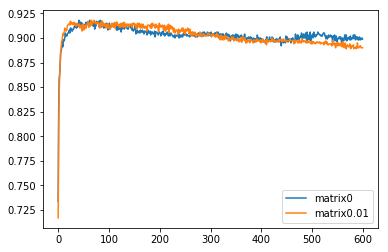

In [73]:
nn1 = AANN([400, 15, 10], aa_iterations=3, regularizer_factor = 0)
nnr1 = nn1.fit(X_test, y_test, X_train, y_train, 600, 20)

nn2 = AANN([400, 15, 10], aa_iterations=3, regularizer_factor = 0.0001)
nnr2 = nn2.fit(X_test, y_test, X_train, y_train, 600, 20)

plt.plot(nnr1[1], label = "matrix0")
plt.plot(nnr2[1], label = "matrix0.01")

plt.legend(loc='lower right')
#plt.ylim([0.89, 0.93])
plt.show()